In [2]:
from supervised_utils import *

### Task di regressione su `score`

#### Addestramento e tuning sul dataset originale

In [3]:
df = pd.read_csv('../dataset/movies_v2.csv')

# colonne per l'addestramento
cols_to_retain = ['rating', 'genre', 'year', 'score', 'votes', 'budget', 'gross', 'runtime']

cols = {
    'target': 'score',
    'drop': list(df.columns.difference(cols_to_retain)),
    'dummies': ['rating', 'genre'],
    'labels': [],
    'round': [],
    'standardize': ['runtime'],
    'log_standardize': ['votes', 'budget', 'gross'],
    'minmax': ['year']
}

--------------------------------------------------------------------------------

Training and tuning [Ridge_Regressor]...

Results after GridSearchCV:
Best parameters: {'alpha': 2}
Best score: {'mean_squared_error': 0.4487}


Test score for [Ridge_Regressor]:
MSE: 0.4532
MAE: 0.4944



--------------------------------------------------------------------------------

Training and tuning [Decision_Tree_Regressor]...

Results after GridSearchCV:
Best parameters: {'criterion': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 10}
Best score: {'mean_squared_error': 0.5591}

Results after max_depth tuning:
Best parameters: {'max_depth': 7}
Best score: {'mean_squared_error': 0.5375}


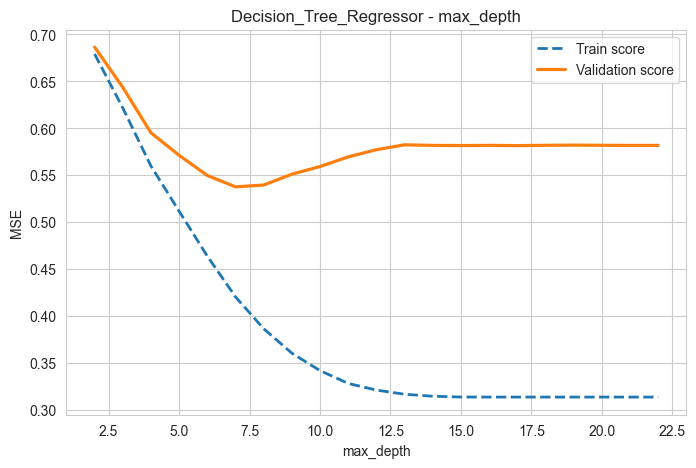


Test score for [Decision_Tree_Regressor]:
MSE: 0.5453
MAE: 0.5468



--------------------------------------------------------------------------------

Training and tuning [Random_Forest_Regressor]...



In [4]:
# tuning e testing dei modelli
tune_and_test_models_for_regression(df, cols, session_name='original')

#### Addestramento e tuning sul primo dataset derivato

In [ ]:
df = pd.read_csv('../dataset/movies_not_binned.csv')

# colonne per l'addestramento
cols_to_retain = ['rating', 'genre', 'score', 'profit_index', 'age', 'runtime', 'votes', 'budget', 'gross',
                  'director_num_movies', 'director_profit_mean', 'director_profit_std', 'director_score_mean', 'director_score_std',
                  'actor_num_movies', 'actor_profit_mean', 'actor_profit_std', 'actor_score_mean', 'actor_score_std']

cols = {
    'target': 'score',
    'drop': list(df.columns.difference(cols_to_retain)),
    'dummies': ['rating', 'genre'],
    'labels': [],
    'round': ['profit_index', 'director_profit_mean', 'director_profit_std', 'director_score_mean', 'director_score_std',
              'actor_profit_mean', 'actor_profit_std', 'actor_score_mean', 'actor_score_std'],
    'standardize': ['runtime'],
    'log_standardize': ['votes', 'budget', 'gross'],
    'minmax': ['age', 'director_num_movies', 'actor_num_movies']
}

In [ ]:
# tuning e testing dei modelli
tune_and_test_models_for_regression(df, cols, session_name='not_binned')

#### Addestramento e tuning sul secondo dataset derivato

In [ ]:
df = pd.read_csv('../dataset/movies_binned.csv')

# colonne per l'addestramento
cols_to_retain = ['rating', 'genre', 'score', 'profitability', 'age', 'runtime', 'votes', 'budget', 'gross',
                  'director_num_movies', 'director_profit_mean', 'director_profit_std', 'director_score_mean', 'director_score_std',
                  'actor_num_movies', 'actor_profit_mean', 'actor_profit_std', 'actor_score_mean', 'actor_score_std']

cols = {
    'target': 'score',
    'drop': list(df.columns.difference(cols_to_retain)),
    'dummies': ['rating', 'genre', 'profitability', 'age', 'runtime', 'votes', 'budget', 'gross', 
                'director_num_movies', 'director_profit_mean', 'director_profit_std', 'director_score_mean', 'director_score_std',
                'actor_num_movies', 'actor_profit_mean', 'actor_profit_std', 'actor_score_mean', 'actor_score_std'],
    'labels': [],
    'standardize': [],
    'log_standardize': [],
    'minmax': []
}

In [ ]:
# tuning e testing dei modelli
tune_and_test_models_for_regression(df, cols, session_name='binned')

### Task di classificazione su `profitability`